In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [3]:
preprocessed_df=pd.read_csv('preprocessing_dataset.csv')

In [4]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column', 'dtypes']]
    
    summary['#Missing'] = df.isnull().sum().values
    summary['#Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values
    
    # Calculate entropy for each column
    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)
    
    
     # Create a separate DataFrame for numerical statistics
    numerical_cols = df.select_dtypes(include=['number']).columns
    numerical_summary = pd.DataFrame(index=numerical_cols)
    numerical_summary['Mean'] = df[numerical_cols].mean()
    numerical_summary['Median'] = df[numerical_cols].median()
    numerical_summary['StdDev'] = df[numerical_cols].std()
    numerical_summary['Min'] = df[numerical_cols].min()
    numerical_summary['Max'] = df[numerical_cols].max()
    
    # Merge numerical statistics with the summary DataFrame
    summary = summary.merge(numerical_summary, left_on='Column', right_index=True, how='left')
    
   
    
    
    return summary


In [5]:
df_summary(preprocessed_df)

Dataset Shape: (117329, 39)


,Column,dtypes,#Missing,#Unique,Example,Entropy,Mean,Median,StdDev,Min,Max
0,order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43,NaN,NaN,NaN,NaN,NaN
1,customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43,NaN,NaN,NaN,NaN,NaN
2,order_status,object,0,7,delivered,0.19,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,object,0,97370,2017-10-02 10:56:33,16.42,NaN,NaN,NaN,NaN,NaN
4,order_approved_at,object,15,89533,2017-10-02 11:07:15,16.26,NaN,NaN,NaN,NaN,NaN
5,order_delivered_carrier_date,object,1235,80449,2017-10-04 19:55:00,16.02,NaN,NaN,NaN,NaN,NaN
6,order_delivered_customer_date,object,2471,95021,2017-10-10 21:25:13,16.39,NaN,NaN,NaN,NaN,NaN
7,order_estimated_delivery_date,object,0,449,2017-10-18,8.47,NaN,NaN,NaN,NaN,NaN
8,review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43,NaN,NaN,NaN,NaN,NaN
9,review_score,int64,0,5,4,1.77,4.031467,5.00,1.387927,1.00,5.00


### Feature Engineering

In this section, I perform feature engineering. Feature engineering is the process of transforming raw data into features that can be used to train a machine learning model. I hope to improve the modeling process through feature engineering.

First, I can improve the performance of my models by creating features that are more relevant and predictive. Moreover, I can reduce the complexity of the model by creating fewer, more meaningful features. Techniques like PCA might be considered. This can make the models easier to interpret and can help prevent overfitting. Lastly, feature engineering can help me make the most of the data by extracting as much useful information as possible from it.

Note that most feature engineering is included in this section, but some others that relate to specific models are done right before the models. I think it makes more sense to leave those with their targeted model to maintain a logical flow for readers.

In [6]:
preprocessed_df['review_score'].dtype

dtype('int64')

### Imbalanced Review Scores

When analyzing the `review_score` distribution, we notice that score 5 is significantly more frequent than other scores. This results in an imbalanced dataset, meaning that one category dominates, making it difficult for models to learn meaningful patterns from the minority classes (scores 1–4).

#### Why is this a Problem?

- **Biased Predictions**: If we train a machine learning model on an imbalanced dataset, the model is likely to favor the majority class (score 5) and ignore the minority classes (scores 1, 2, 3, 4). This reduces the model's ability to accurately predict reviews with lower scores.

- **Misleading Insights**: If we rely on raw scores, it may appear that most customers are highly satisfied when, in reality, there could be many dissatisfied customers whose voices are being overshadowed.

- **Poor Generalization**: A model trained on an imbalanced dataset may fail to generalize when applied to new data, especially if future reviews contain a different distribution of scores.

In [7]:
print("The Number of customers giving one rating is {}".format(len(preprocessed_df[preprocessed_df['review_score'] == 1])))
print("The Number of customers giving two rating is {}".format(len(preprocessed_df[preprocessed_df['review_score'] == 2])))
print("The Number of customers giving third rating is {}".format(len(preprocessed_df[preprocessed_df['review_score'] == 3])))
print("The Number of customers giving four rating is {}".format(len(preprocessed_df[preprocessed_df['review_score'] == 4])))
print("The Number of customers giving five rating is {}".format(len(preprocessed_df[preprocessed_df['review_score'] == 5])))


The Number of customers giving one rating is 14854
The Number of customers giving two rating is 4085
The Number of customers giving third rating is 9840
The Number of customers giving four rating is 22286
The Number of customers giving five rating is 66264


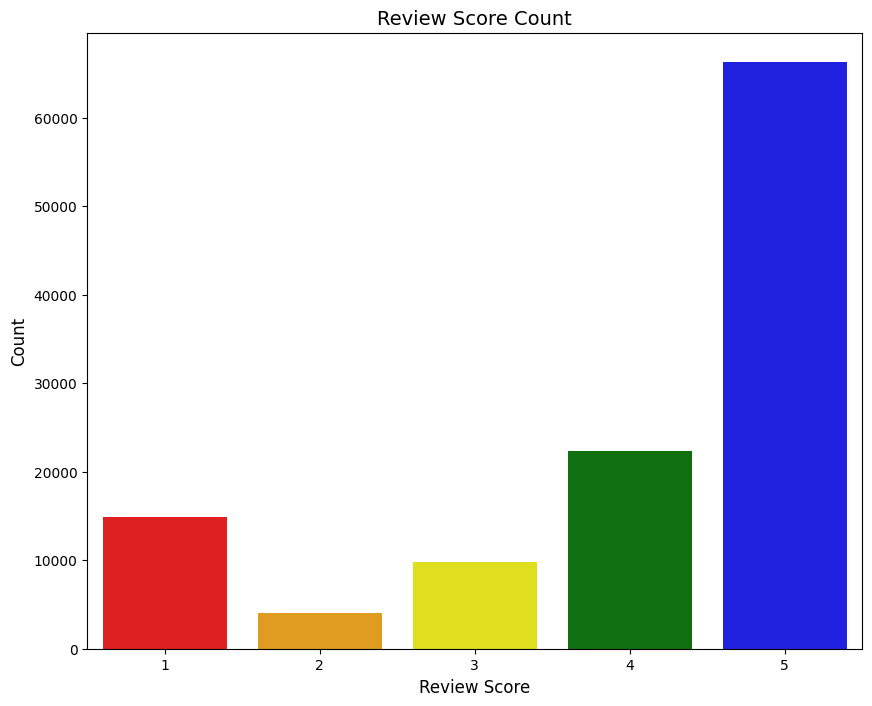

In [8]:
plt.figure(figsize=(10,8))
sns.barplot(x=[1,2,3,4,5], 
            y=[14854,4085,9840,22286,66264], 
            palette=["red", "orange", "yellow", "green", "blue"])
plt.title("Review Score Count", fontsize=14)
plt.xlabel("Review Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [9]:
#cloning preprocessing_df into feature_df which will be used for modelling later
feature_df=preprocessed_df
feature_df.loc[feature_df['review_score'] == 5, "review_score_factor"] = 2
feature_df.loc[feature_df['review_score'] <= 4, "review_score_factor"] = 1
feature_df.loc[feature_df['review_score'] <= 2, "review_score_factor"] = 0


In [10]:
feature_df['review_score_factor']


0         1.0
1         1.0
2         1.0
3         1.0
4         2.0
         ... 
117324    1.0
117325    2.0
117326    0.0
117327    0.0
117328    2.0
Name: review_score_factor, Length: 117329, dtype: float64

### Solution: Categorizing Review Scores into Three Groups

To handle the imbalance in review scores, we group the review scores into three categories and create a new column called `review_score_factor`:

- **Low Satisfaction (0)** → Scores 1 or 2 (indicating a poor experience)
- **Medium Satisfaction (1)** → Scores 3 or 4 (neutral/mixed experience)
- **High Satisfaction (2)** → Score 5 (indicating a good experience)

This approach helps by:
- ✅ **Reducing Class Imbalance** – Instead of dealing with five separate categories, we now have three, making it easier for models to learn.
- ✅ **Simplifying Interpretation** – It provides a clearer picture of customer satisfaction levels.
- ✅ **Improving Model Performance** – With fewer classes, classification models can perform better.

### Changing `price` and `freight_value` into Categorical

#### Problem

The dataset includes three key variables:

- **payment_value** → The total transaction value for an entire order.
- **price** → The cost of an individual item in an order.
- **freight_value** → The shipping cost for an individual item.

#### Challenges:

1. **High Correlation**: `payment_value` is calculated as the sum of `price` and `freight_value`, making these variables highly correlated. Using all three in modeling can lead to redundancy and multicollinearity, which negatively impacts predictive performance.

2. **Different Levels of Aggregation**: While `price` and `freight_value` refer to individual items, `payment_value` represents an entire order. Since ratings are given for the entire order, analyzing `price` and `freight_value` at the item level may not directly contribute to understanding customer satisfaction.

3. **Uneven Distribution**: `price` and `freight_value` have a wide range of values with potential outliers. If used as continuous numerical features, they might introduce bias in certain machine learning models, leading to overfitting or difficulty in interpretation.


In [11]:
price_median=feature_df['price'].median()
feature_df.loc[feature_df['price']>=price_median,'price_factor']=1
feature_df.loc[feature_df['price']<price_median,'price_factor']=0


In [12]:
freight_value_median=feature_df['freight_value'].median()
feature_df.loc[feature_df['freight_value']>=freight_value_median,'freight_value_factor']=1
feature_df.loc[feature_df['freight_value']<freight_value_median,'freight_value_factor']=0



### Solution

To address these challenges, we convert `price` and `freight_value` into categorical variables using the 50th percentile (median split). This simplifies the analysis while preserving meaningful distinctions between high and low values.

#### Creating `price_factor` (Categorical Price Classification)

- `price_factor = 0` → If `price` is below the 50th percentile (lower-priced items).
- `price_factor = 1` → If `price` is equal to or above the 50th percentile (higher-priced items).

#### Creating `freight_value_factor` (Categorical Freight Cost Classification)

- `freight_value_factor = 0` → If `freight_value` is below the 50th percentile (lower shipping costs).
- `freight_value_factor = 1` → If `freight_value` is equal to or above the 50th percentile (higher shipping costs).

#### Benefits of This Approach:

- ✅ **Reduces Multicollinearity** → Avoids redundancy by focusing on `payment_value` while simplifying `price` and `freight_value`.
- ✅ **Improves Model Interpretability** → Instead of working with raw numerical values, models can learn patterns based on broad categories.
- ✅ **Handles Uneven Distributions** → By grouping prices and freight costs, we reduce the impact of extreme values and outliers.
- ✅ **Better Alignment with Ratings** → Since ratings are based on the entire order, categorizing `price` and `freight_value` aligns better with how customers perceive the total purchase experience rather than focusing on small price variations.


### Packaged Delivered or Not

During Exploratory Data Analysis (EDA), I observed that `order_status` has an impact on review scores. Specifically, when an order is not delivered, it tends to receive lower ratings from customers.

However, the `order_status` column contains 7 different categories, including:

- Delivered (successful orders)
- Non-delivered statuses like shipped, canceled, invoiced, processing, and created

Using all 7 categories in my analysis might not be helpful because:

- Some categories have very few orders, making them statistically insignificant.
- The differences among non-delivered statuses are not meaningful for predicting ratings. For example, whether an order is shipped or canceled, the impact on the rating is usually similar.
- Too many categories can make the model more complex without adding much value.


In [13]:
feature_df.loc[feature_df['order_status'] == 'delivered', "if_delivered"] = 1
feature_df.loc[feature_df['order_status'] != 'delivered', "if_delivered"] = 0

### Differences in Estimated and Actual Delivery Date

#### Problem

When customers place an order online, they expect to receive their package on time. If a package is delivered late, it can lead to negative reviews. To analyze this, we need to compare the actual delivery date with the estimated delivery date.

However, there are two major issues in our dataset:

1. **Missing Values in Delivery Dates**

    - Some orders do not have an actual delivery date (`order_delivered_customer_date` is NaN).
    - The main reason for this is that these orders were never delivered (e.g., canceled, returned, or still in transit).

2. **Difficulty in Measuring Delivery Delays**

    - If an order has no actual delivery date, we cannot determine if it was delivered late or on time.
    - This missing data can distort our ability to analyze how delivery timing affects review scores.

In [14]:
non_delivered = feature_df[feature_df['if_delivered'] == 0]
nan_delivered_customer_count = non_delivered[non_delivered['order_delivered_customer_date'].isnull()]['order_id'].nunique()
print(f'There are {nan_delivered_customer_count} rows isnull in order_delivered_customer_date column for all non_delivered rows')

There are 2079 rows isnull in order_delivered_customer_date column for all non_delivered rows


In [15]:
feature_df.loc[feature_df['order_delivered_customer_date'].isnull(), "order_delivered_customer_date"] = feature_df['order_estimated_delivery_date']

In [16]:
feature_df['order_estimated_delivery_date'] = pd.to_datetime(feature_df['order_estimated_delivery_date'], errors='coerce')
feature_df['order_delivered_customer_date'] = pd.to_datetime(feature_df['order_delivered_customer_date'], errors='coerce')
feature_df['actual_est_delivery_diff'] = (feature_df['order_estimated_delivery_date'] - feature_df['order_delivered_customer_date']).dt.days

### Solution

To handle this issue, we fill missing values in `order_delivered_customer_date` with `order_estimated_delivery_date`. This ensures that:

- **✅ Data Completeness**: Prevents errors due to NaN values and allows consistent calculations.
- **✅ Better Prediction Stability**: Assigning `actual_est_delivery_diff = 0` for missing cases avoids introducing unnecessary variations in model training.
- **✅ Logical Handling of Missing Values**: Since missing values are primarily due to non-delivery, they are separately handled using the `if_delivered` flag during prediction.

By implementing this approach, we maintain dataset integrity while accurately analyzing delivery performance and its impact on ratings.

**How long it took to receive the package**

In [17]:
feature_df['order_purchase_timestamp']=pd.to_datetime(feature_df['order_purchase_timestamp'],errors='coerce')
feature_df['delivery_duration'] = (feature_df['order_delivered_customer_date'] - feature_df['order_purchase_timestamp']).dt.days 

**Some Nan data**

In [18]:
feature_df.loc[feature_df['product_photos_qty'].isnull(), "product_photos_qty"] = 0
feature_df.loc[feature_df['product_description_length'].isnull(), "product_description_length"] = 0
feature_df = feature_df.dropna(subset=['product_weight_g'])

### Why am I making these adjustments?

#### Setting `product_photos_qty` and `product_description_length` to 0 when null:

- **Indication of Missing Data**: Missing values in these columns likely indicate that the product listing did not include photos or descriptions.
- **Data Completeness**: Setting them to 0 ensures that the dataset remains complete without introducing artificial values.
- **Error Prevention**: This prevents errors in calculations and allows the model to recognize missing descriptions/photos as a potential feature.

#### Dropping rows without a weight (`product_weight_g` is null):

- **Critical Attribute**: Weight is a critical attribute for logistics, shipping cost calculations, and delivery time predictions.
- **Data Accuracy**: If a product has no recorded weight, it becomes difficult to accurately process shipping-related data.
- **Essential for Fulfillment**: Unlike descriptions or photos, weight is essential for fulfillment, and missing values here suggest incomplete or erroneous records.
- **Maintaining Data Quality**: Rather than filling with an arbitrary value, I drop these rows to maintain data quality and avoid misleading analysis.

In [19]:
preprocessed_df['customer_state'].value_counts()

customer_state
SP    49527
RJ    15220
MG    13616
RS     6516
PR     5959
SC     4283
BA     4014
DF     2482
GO     2416
ES     2319
PE     1876
CE     1545
MT     1117
PA     1102
MS      854
MA      843
PB      629
PI      568
RN      566
AL      459
SE      395
TO      338
RO      285
AM      170
AC       95
AP       83
RR       52
Name: count, dtype: int64

In [20]:
d1=pd.get_dummies(feature_df.loc[:,['customer_state','seller_state']])
feature_df=pd.concat([feature_df,d1],axis=1)

### Why Perform One-Hot Encoding for `customer_state` and `seller_state`?

1. **Handling Categorical Data for Machine Learning**:
    - `customer_state` and `seller_state` are categorical variables, meaning they contain names of states rather than numerical values. Most machine learning models cannot directly work with categorical text data, so one-hot encoding is used to convert them into a numeric format.

2. **Why Not Use Label Encoding Instead?**:
    - Label encoding assigns integer values to each category (e.g., "SP" → 1, "RJ" → 2), but this creates an artificial order between categories, which does not make sense for state names. One-hot encoding avoids this issue by treating categories independently.

3. **Avoiding Data Loss in Feature Engineering**:
    - By using `pd.get_dummies()`, no information is lost—each state is represented as a separate feature, allowing models to understand the presence or absence of a particular state in an observation.


### Product Categories

While analyzing the `product_category_name`, I noticed that some rows in `full_df` lacked information such as the product name, category, description, and photos. Since these rows were likely errors or test data, I removed those without a product name before applying one-hot encoding to the product category.

In [27]:
feature_df=feature_df.dropna(subset=['product_name_length'])


In [35]:
from googletrans import Translator
from deep_translator import GoogleTranslator

In [37]:

translator = GoogleTranslator(source='auto', target='en')
feature_df['product_category_name_english'] = feature_df['product_category_name'].apply(
    lambda x: translator.translate(x)
)

KeyboardInterrupt: 

In [39]:
d2=pd.get_dummies(feature_df.loc[:,['product_category_name']])
feature_df=pd.concat([feature_df,d2],axis=1)

In [40]:
df_summary(feature_df)

Dataset Shape: (115633, 168)


,Column,dtypes,#Missing,#Unique,Example,Entropy,Mean,Median,StdDev,Min,Max
0,order_id,object,0,96536,e481f51cbdc54678b7cc49136f2d6af7,16.41,NaN,NaN,NaN,NaN,NaN
1,customer_id,object,0,96536,9ef432eb6251297304e76186b10a928d,16.41,NaN,NaN,NaN,NaN,NaN
2,order_status,object,0,7,delivered,0.18,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,datetime64[ns],0,96009,2017-10-02 10:56:33,16.40,NaN,NaN,NaN,NaN,NaN
4,order_approved_at,object,14,88343,2017-10-02 11:07:15,16.24,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
163,product_category_name_sinalizacao_e_seguranca,bool,0,2,False,0.02,NaN,NaN,NaN,NaN,NaN
164,product_category_name_tablets_impressao_imagem,bool,0,2,False,0.01,NaN,NaN,NaN,NaN,NaN
165,product_category_name_telefonia,bool,0,2,False,0.24,NaN,NaN,NaN,NaN,NaN
166,product_category_name_telefonia_fixa,bool,0,2,False,0.02,NaN,NaN,NaN,NaN,NaN


In [42]:
feature_df.to_pickle('preprocessing_dataset.pickle')